# Architecture : HED + VIT + TFID, You may training kernel [here](https://www.kaggle.com/ajaykumar7778/shopee-pytorch-vit-image-training-20-epochs)
https://github.com/s9xie/hed

## Initialization

In [37]:
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')

In [38]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import math
import random 
import os
import shutil
import cv2
import timm
import csv
import glob

from tqdm import tqdm 

import albumentations as A 
from albumentations.pytorch.transforms import ToTensorV2

import torch 
from torch.utils.data import Dataset 
from torch import nn
import torch.nn.functional as F 

if torch.cuda.is_available():
    import gc
    import cudf
    import cuml
    import cupy
    from cuml.feature_extraction.text import TfidfVectorizer
    from cuml.neighbors import NearestNeighbors

## Classes

In [39]:
class CFG:
    
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    MODEL_NAME = 'vit_base_patch16_384'
    MODEL_PATH = '../input/shopee-vit-20-epochs/vit_16_384(mish)_9.pt'
    TEST_DIR = '../input/shopee-product-matching/test_images/'
    TRAIN_DIR = '../input/shopee-product-matching/train_images/'
    TEST_CSV = '../input/shopee-product-matching/test.csv'
    TRAIN_CSV = '../input/shopee-product-matching/train.csv'
    DNN_CTR_IMG_DIRNAME = '../input/shopee-cv-dnn-image-contour-preprocessed/shopee-dnn-ctr-images/shopee-dnn-ctr-images/'
    DNN_MASKED_IMG_DIRNAME = '../input/shopee-cv-dnn-image-contour-preprocessed/shopee-dnn-masked-images/shopee-dnn-masked-images/'
    DNN_CTR_OUT_IMG_DIR = './dnn-ctr-imgs/'
    DNN_MASKED_OUT_IMG_DIR = './dnn-masked-imgs/'
    
    CLASSES = 11014
    SCALE = 30 
    MARGIN = 0.5
    FC_DIM = 512
    BATCH_SIZE = 25
    SEED = 2020
    NUM_WORKERS = 2
    IMG_SIZE = 384#512
    MEAN = [190.78931247, 182.19326677, 176.63394215]
    STD = [40.35300913, 41.45103731, 45.02971443]
    IMG_THRESHOLD = 0.42
    TXT_THRESHOLD = 0.75
    MAX_FEATS = 25000
    CHUNK_SIZE = 1024*4
    NUM_KNN = 1
    
    IMG_SUBKEY = 'images'
    IMG_NAMES_SUBKEY = 'names'
    IMG_SIZE_SUBKEY = 'size'
    START_IDX_SUBKEY = 'start'
    END_IDX_SUBKEY = 'end'
    UUID_SUBKEY = 'id'
    KEY_SEP = '_' # Note: Use this separator to get dataset info from the table key (<sub_key><sep><value>)
    NAME_SEP = ';' # Note: Uuse this separator to get the list of image names from the CSV file
    
    START_IDX = -1 # Note: The start index of the input dataset to start processing from
    END_IDX = -1 # Note: The end index of the input dataset to stop processing to

In [40]:
class ArcMarginProduct(nn.Module):
    def __init__(self, in_features, out_features, scale=30.0, margin=0.50, easy_margin=False, ls_eps=0.0):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.scale = scale
        self.margin = margin
        self.ls_eps = ls_eps  # label smoothing
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(margin)
        self.sin_m = math.sin(margin)
        self.th = math.cos(math.pi - margin)
        self.mm = math.sin(math.pi - margin) * margin

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        # --------------------------- convert label to one-hot ---------------------------
        # one_hot = torch.zeros(cosine.size(), requires_grad=True, device='cuda')
        one_hot = torch.zeros(cosine.size(), device='cuda')
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.out_features
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.scale

        return output

# class ShopeeModel(nn.Module):

#     def __init__(
#         self,
#         n_classes = CFG.classes,
#         model_name = CFG.model_name,
#         fc_dim = 512,
#         margin = CFG.margin,
#         scale = CFG.scale,
#         use_fc = True,
#         pretrained = False):


#         super(ShopeeModel,self).__init__()
#         print('Building Model Backbone for {} model'.format(model_name))

#         self.backbone = timm.create_model(model_name, pretrained=pretrained)

#         if model_name == 'resnext50_32x4d':
#             final_in_features = self.backbone.fc.in_features
#             self.backbone.fc = nn.Identity()
#             self.backbone.global_pool = nn.Identity()

#         elif model_name == 'efficientnet_b3':
#             final_in_features = self.backbone.classifier.in_features
#             self.backbone.classifier = nn.Identity()
#             self.backbone.global_pool = nn.Identity()

#         elif model_name == 'tf_efficientnet_b5_ns':
#             final_in_features = self.backbone.classifier.in_features
#             self.backbone.classifier = nn.Identity()
#             self.backbone.global_pool = nn.Identity()
        
#         elif model_name == 'eca_nfnet_l0':
#             final_in_features = self.backbone.head.fc.in_features
#             self.backbone.head.fc = nn.Identity()
#             self.backbone.head.global_pool = nn.Identity()

#         self.pooling =  nn.AdaptiveAvgPool2d(1)

#         self.use_fc = use_fc

#         self.dropout = nn.Dropout(p=0.0)
#         self.fc = nn.Linear(final_in_features, fc_dim)
#         self.bn = nn.BatchNorm1d(fc_dim)
#         self._init_params()
#         final_in_features = fc_dim

#         self.final = ArcMarginProduct(
#             final_in_features,
#             n_classes,
#             scale = scale,
#             margin = margin,
#             easy_margin = False,
#             ls_eps = 0.0
#         )

#     def _init_params(self):
#         nn.init.xavier_normal_(self.fc.weight)
#         nn.init.constant_(self.fc.bias, 0)
#         nn.init.constant_(self.bn.weight, 1)
#         nn.init.constant_(self.bn.bias, 0)

#     def forward(self, image, label):
#         feature = self.extract_feat(image)
#         #logits = self.final(feature,label)
#         return feature

#     def extract_feat(self, x):
#         batch_size = x.shape[0]
#         x = self.backbone(x)
#         x = self.pooling(x).view(batch_size, -1)

#         if self.use_fc:
#             x = self.dropout(x)
#             x = self.fc(x)
#             x = self.bn(x)
#         return x

In [41]:
class Mish_func(torch.autograd.Function):
    
    """from: https://github.com/tyunist/memory_efficient_mish_swish/blob/master/mish.py"""
    
    @staticmethod
    def forward(ctx, i):
        result = i * torch.tanh(F.softplus(i))
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_variables[0]
        v = 1. + i.exp()
        h = v.log() 
        grad_gh = 1./h.cosh().pow_(2)
        grad_hx = i.sigmoid()
        grad_gx = grad_gh *  grad_hx #grad_hv * grad_vx 
        grad_f =  torch.tanh(F.softplus(i)) + i * grad_gx 
        
        return grad_output * grad_f 


class Mish(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        pass
    def forward(self, input_tensor):
        return Mish_func.apply(input_tensor)


def replace_activations(model, existing_layer, new_layer):
    
    """A function for replacing existing activation layers"""
    
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            model._modules[name] = replace_activations(module, existing_layer, new_layer)

        if type(module) == existing_layer:
            layer_old = module
            layer_new = new_layer
            model._modules[name] = layer_new
    return model

In [42]:
class ShopeeDataset(Dataset):
    def __init__(self, image_paths, transforms=None):
        self.image_paths = image_paths
        self.augmentations = transforms

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.augmentations:
            augmented = self.augmentations(image=image)
            image = augmented['image']
    
        return image,torch.tensor(1)
    
    def get_mean_std_rgb(self, img_size):
        mean = np.array([0.0, 0.0, 0.0])
        std = np.array([0.0, 0.0, 0.0])
        num_imgs = self.__len__()
        for idx in tqdm(range(num_imgs), desc='Acquiring the mean for the dataset'):
            row = self.df.iloc[idx]
            img_path = os.path.join(self.root_dir,row.image)
            image = cv2.imread(img_path)
            image = cv2.resize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), (img_size, img_size), interpolation=cv2.INTER_AREA)
            mean += np.mean(np.reshape(image, (-1, image.shape[2])), axis=0)
        
        mean /= num_imgs
        for idx in tqdm(range(num_imgs), desc='Acquiring the standard deviation for the dataset'):
            row = self.df.iloc[idx]
            img_path = os.path.join(self.root_dir,row.image)
            image = cv2.imread(img_path)
            image = cv2.resize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), (img_size, img_size), interpolation=cv2.INTER_AREA)
            std += (np.mean(np.reshape(image, (-1, image.shape[2])), axis=0) - mean) ** 2
        
        std = np.sqrt(std / num_imgs)
        return (mean, std)

    def set_transforms(self, transforms=None):
        self.augmentations = transforms

In [43]:

class ShopeeModel(nn.Module):

    def __init__(
        self,
        cfg,
        fc_dim = 512,
        use_fc = True,
        pretrained = False):


        # Initialize Values
        n_classes = cfg.CLASSES
        model_name = cfg.MODEL_NAME
        margin = cfg.MARGIN
        scale = cfg.SCALE
        
        super(ShopeeModel,self).__init__()
        print('Building Model Backbone for {} model'.format(model_name))
        self.backbone = timm.create_model(model_name, pretrained=pretrained)
        if pretrained:
            self.backbone.load_state_dict(torch.load(cfg.MODEL_PATH, map_location=torch.device(cfg.DEVICE)))
        
        if model_name == 'vit_base_patch16_384':
            final_in_features = self.backbone.head.in_features
        
        if model_name == 'resnext50_32x4d':
            final_in_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()
            self.backbone.global_pool = nn.Identity()

        elif 'efficientnet' in model_name:
            final_in_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Identity()
            self.backbone.global_pool = nn.Identity()
        
        elif 'nfnet' in model_name:
            final_in_features = self.backbone.head.fc.in_features
            self.backbone.head.fc = nn.Identity()
            self.backbone.head.global_pool = nn.Identity()

        self.pooling =  nn.AdaptiveAvgPool2d(1)

        self.use_fc = use_fc
        if use_fc:
            self.dropout = nn.Dropout(p=0.0)
            self.fc = nn.Linear(1000, fc_dim)
            self.bn = nn.BatchNorm1d(fc_dim)
            self._init_params()
            final_in_features = fc_dim

        self.final = ArcMarginProduct(
            final_in_features,
            n_classes,
            scale = scale,
            margin = margin,
            easy_margin = False,
            ls_eps = 0.0
        )

    def _init_params(self):
        nn.init.xavier_normal_(self.fc.weight)
        nn.init.constant_(self.fc.bias, 0)
        nn.init.constant_(self.bn.weight, 1)
        nn.init.constant_(self.bn.bias, 0)

    def forward(self, image, label):
        feature = self.extract_feat(image)
        logits = self.final(feature,label)
        return logits

    def extract_feat(self, x):
        batch_size = x.shape[0]
        x = self.backbone(x)

        if self.use_fc:
            x = self.dropout(x)
            x = self.fc(x)
            x = self.bn(x)
        return x

## Functions

### H5 Image Dataset

In [44]:
def get_h5_dataset_info(cfg, key):
    # Get dataset info from key
    key_info = key.split(cfg.KEY_SEP)
    uuid = key_info[key_info.index(cfg.UUID_SUBKEY) + 1]
    img_size = int(key_info[key_info.index(cfg.IMG_SIZE_SUBKEY) + 1])
    start_idx = int(key_info[key_info.index(cfg.START_IDX_SUBKEY) + 1])
    end_idx = int(key_info[key_info.index(cfg.END_IDX_SUBKEY) + 1])
    num_imgs = int(end_idx - start_idx)
    
    return (uuid, img_size, start_idx, end_idx, num_imgs)

In [45]:
def save_h5_images(cfg, h5_dataset_path, csv_filepath, outdir, img_channels=3):
    img_names = []
    with pd.HDFStore(h5_dataset_path, 'r') as hd5store:
        for key in hd5store.keys():            
            # Get dataset info from key
            uuid, img_size, start_idx, end_idx, num_imgs = get_h5_dataset_info(cfg, key)
            if DEBUG:
                print(f'uuid: {uuid}, img_size: {img_size}, start_idx: {start_idx}, end_idx: {end_idx}, num_imgs: {num_imgs}')

            # Get image names
            cur_imgnames = []
            with open(csv_filepath, 'rt') as csvfile:
                reader = csv.reader(csvfile, delimiter=',')
                header = next(reader)
                for row in reader:
                    if uuid == row[0]:
                        cur_imgnames = row[-1].replace(' ', '').split(cfg.NAME_SEP)
            
            img_names += cur_imgnames

            # Get and save images
            imgs = np.resize(hd5store.select(key).to_numpy(), (num_imgs, img_size, img_size, img_channels))
            for i in tqdm(range(len(imgs)), desc=f'Saving h5 images to {outdir}'):
                img = imgs[i]
                imgname = cur_imgnames[i]
                if img_channels == 1:
                    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
                
                cv2.imwrite(outdir + imgname, img)
            
            del cur_imgnames
            del imgs
            gc.collect()
            
    return img_names


In [46]:
def save_all_h5_images(cfg):
    img_names = []
    
    # Delete existing directories and create fresh ones
    if os.path.isdir(cfg.DNN_CTR_OUT_IMG_DIR):
        shutil.rmtree(cfg.DNN_CTR_OUT_IMG_DIR)

    if os.path.isdir(cfg.DNN_MASKED_OUT_IMG_DIR):
        shutil.rmtree(cfg.DNN_MASKED_OUT_IMG_DIR)
    
    if not os.path.isdir(cfg.DNN_CTR_OUT_IMG_DIR):
        os.mkdir(cfg.DNN_CTR_OUT_IMG_DIR)
    
    if not os.path.isdir(cfg.DNN_MASKED_OUT_IMG_DIR):
        os.mkdir(cfg.DNN_MASKED_OUT_IMG_DIR)
        
    # Acquire and save all DNN-Contour and masked images
    csv_filenames = glob.glob(f'{cfg.DNN_CSV_BASENAME}*.csv')
    csv_filenames.sort()
    ctr_h5_filenames = glob.glob(f'{cfg.DNN_CTR_HD5_BASENAME}*.h5')
    ctr_h5_filenames.sort()
    masked_h5_filenames = glob.glob(f'{cfg.DNN_MASKED_HD5_BASENAME}*.h5')
    masked_h5_filenames.sort()
    num_files = min([len(csv_filenames), len(ctr_h5_filenames), len(masked_h5_filenames)])
    for file_idx in range(num_files):
        img_names += save_h5_images(cfg, ctr_h5_filenames[file_idx], csv_filenames[file_idx], cfg.DNN_CTR_OUT_IMG_DIR, img_channels=1)
        save_h5_images(cfg, masked_h5_filenames[file_idx], csv_filenames[file_idx], cfg.DNN_MASKED_OUT_IMG_DIR, img_channels=3)
    
    return img_names

### Dataframe

In [47]:
def get_dataframe(cfg, csv_path, img_rootdir, imgname_key):
    begin_skip_indices = range(1, cfg.START_IDX + 1) if cfg.START_IDX != -1 else []
    end_skip_count = 34251 - (cfg.END_IDX + 1) if cfg.END_IDX != -1 else 0
    df = pd.read_csv(csv_path, skiprows=begin_skip_indices, skipfooter=end_skip_count, engine='python') 
    if DEBUG:
        print(f'begin_skip_indices: {begin_skip_indices}, end_skip_count: {end_skip_count}, END_IDX: {cfg.END_IDX}')
        print(f'BDUB - df keys: {df.keys()}, df len: {len(df)}')

    tmp = df.groupby(['label_group'])['posting_id'].unique().to_dict()
    df['true_matches'] = df['label_group'].map(tmp)
    df['true_matches'] = df['true_matches'].apply(lambda x: ' '.join(x))
    df_cu = cudf.DataFrame(df)
    image_paths = img_rootdir + df[imgname_key]
    return (df, df_cu, image_paths)

In [48]:
def get_testloader(cfg, img_paths):
    testset = ShopeeDataset(img_paths)
    if DEBUG:
        print(f'Number of image paths: {len(img_paths)}')
    
    # Get the mean and std of the images to setup the transform function
    #mean, std = testset.get_mean_std_rgb(cfg.IMG_SIZE)
    testset.set_transforms(get_test_transforms(cfg, cfg.MEAN, cfg.STD))
    #if DEBUG:
    #    print(f'RGB Mean: {mean}, Standard-dev: {std}')
    
    # Setup the data loader
    testloader = torch.utils.data.DataLoader(
        testset,
        batch_size = cfg.BATCH_SIZE,
        pin_memory = True,
        num_workers = cfg.NUM_WORKERS,
        shuffle = True,
        drop_last = False
    )
    
    return testloader

### Model

In [49]:
def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [50]:
def get_test_transforms(cfg, in_mean, in_std):
    return A.Compose(
        [
            A.Resize(cfg.IMG_SIZE, cfg.IMG_SIZE, always_apply=True),
            A.Normalize(mean=in_mean, std=in_std),
            ToTensorV2(p=1.0)
        ]
    )

In [51]:
def get_model(cfg):
    model = ShopeeModel(cfg)
    model.load_state_dict(torch.load(cfg.MODEL_PATH, map_location=torch.device(cfg.DEVICE)))
    model.to(cfg.DEVICE)

    existing_layer = torch.nn.SiLU
    new_layer = Mish()
    model = replace_activations(model, existing_layer, new_layer) # in eca_nfnet_l0 SiLU() is used, but it will be replace by Mish()
    
    return model

### Embeddings

In [52]:
def get_image_embeddings(cfg, model, img_loader):
    embeds = []
    model.eval()
    with torch.no_grad():
        for img,label in tqdm(img_loader, desc='Acquiring image embeddings'): 
            img = img.to(cfg.DEVICE)
            label = label.to(cfg.DEVICE)
            feat = model(img, label)
            image_embeddings = feat.detach().cpu().numpy()
            embeds.append(image_embeddings)
    
    del model
    image_embeddings = np.concatenate(embeds)
    print(f'Our image embeddings shape is {image_embeddings.shape}')
    del embeds
    gc.collect()
    return image_embeddings

### Predictions

In [53]:
def get_image_predictions(df, embeddings, threshold=0.0, num_knn=-1):
    
    if num_knn == -1:
        if len(df) > 3:
            num_knn = 50
        else: 
            num_knn = 3
    
    model = NearestNeighbors(n_neighbors=num_knn, metric='cosine')
    model.fit(embeddings)
    distances, indices = model.kneighbors(embeddings)
    
    predictions = []
    for k in tqdm(range(embeddings.shape[0]), desc='Acquiring image predictions'):
        idx = np.where(distances[k,] < threshold)[0]
        ids = indices[k,idx]
        posting_ids = df['posting_id'].iloc[ids].values
        predictions.append(posting_ids)
        
    del model, distances, indices
    gc.collect()
    return predictions

In [54]:
def get_text_predictions(df, df_cu, max_features=25_000, txt_threshold=0.75, length=-1):
    
    model = TfidfVectorizer(stop_words='english', binary=True, max_features=max_features)
    text_embeddings = model.fit_transform(df_cu['title']).toarray()
    preds = []
    CHUNK = 1024*4

    print('Finding similar titles...')
    length = min(length, len(df)) if length != -1 else len(df)
    CTS = length//CHUNK
    if length%CHUNK !=0: CTS += 1
    for j in tqdm(range(CTS), desc='Acquiring text predictions'):

        a = j*CHUNK
        b = (j+1)*CHUNK
        b = min(b,length)
        
        if DEBUG:
            print('chunk',a,'to',b)

        # COSINE SIMILARITY DISTANCE
        cts = cupy.matmul( text_embeddings, text_embeddings[a:b].T).T

        for k in range(b-a):
            IDX = cupy.where(cts[k,] > txt_threshold)[0]
            o = df.iloc[cupy.asnumpy(IDX)].posting_id.values
            preds.append(o)
    
    del model,text_embeddings
    gc.collect()
    return preds

In [55]:
def combine_predictions(row):
    x = np.concatenate([row['image_predictions'], row['text_predictions']])
    return ' '.join( np.unique(x))

### Scoring

In [56]:
# Function to get our f1 score
def f1_score(y_true, y_pred):
    y_true = y_true.apply(lambda x: set(x.split()))
    y_pred = y_pred.apply(lambda x: set(x.split()))
    intersection = np.array([len(x[0] & x[1]) for x in zip(y_true, y_pred)])
    len_y_pred = y_pred.apply(lambda x: len(x)).values
    len_y_true = y_true.apply(lambda x: len(x)).values
    f1 = 2 * intersection / (len_y_pred + len_y_true)
    return f1

In [57]:
def f1_score_perclass(df, class_key, f1_score_key):
    f1_scores = df[f1_score_key].values
    classes = df[class_key].values
    score_perclass = {}
    for i in range(len(df)):
        classval = str(classes[i])
        if classval not in score_perclass.keys():
            score_perclass[classval] = (0.0, 0.0)
        
        class_score = score_perclass[classval]
        score_perclass[classval] = (class_score[0] + 1.0, class_score[1] + f1_scores[i])

    for key in score_perclass.keys():
        class_score = score_perclass[key]
        score_perclass[key] = class_score[1] / class_score[0]

    return score_perclass

## Processing

### Initialization

In [58]:
DEBUG = True
ACQUIRE_H5_Data = False

In [59]:
cfg = CFG()

### Pre-processing

#### H5 Data

In [60]:
if ACQUIRE_H5_Data:
    h5_imgnames = save_all_h5_images(cfg)
    shutil.make_archive('shopee-dnn-ctr-images', 'zip', cfg.DNN_CTR_OUT_IMG_DIR)
    shutil.make_archive('shopee-dnn-masked-images', 'zip', cfg.DNN_MASKED_OUT_IMG_DIR)

#### Acquire Image Paths

Number of H5 contour images: 32412, masked images: 32412
../input/shopee-cv-dnn-image-contour-preprocessed/shopee-dnn-ctr-images/shopee-dnn-ctr-images/07c251a26b8266c85730ab8d870f1356.jpg


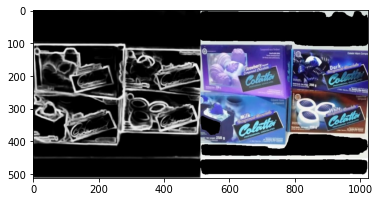

../input/shopee-cv-dnn-image-contour-preprocessed/shopee-dnn-ctr-images/shopee-dnn-ctr-images/36dc46d97cdaa7622793e7016976da46.jpg


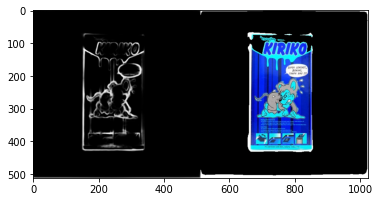

../input/shopee-cv-dnn-image-contour-preprocessed/shopee-dnn-ctr-images/shopee-dnn-ctr-images/b3c7b96aeb0398b152fa5984260a6c57.jpg


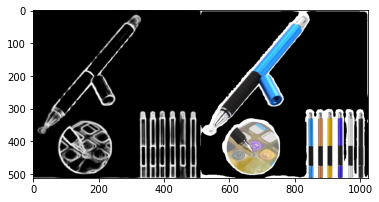

../input/shopee-cv-dnn-image-contour-preprocessed/shopee-dnn-ctr-images/shopee-dnn-ctr-images/1bd82215202e4e261a1eb8311473c450.jpg


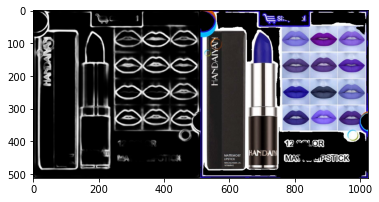

../input/shopee-cv-dnn-image-contour-preprocessed/shopee-dnn-ctr-images/shopee-dnn-ctr-images/0b2c815972b87908af3652d2986a55a7.jpg


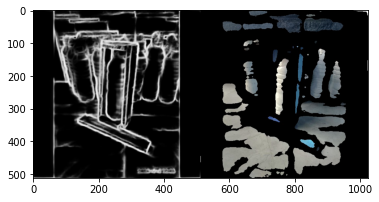

../input/shopee-cv-dnn-image-contour-preprocessed/shopee-dnn-ctr-images/shopee-dnn-ctr-images/540853e2e0f15c1efc4fb0f426bc49c5.jpg


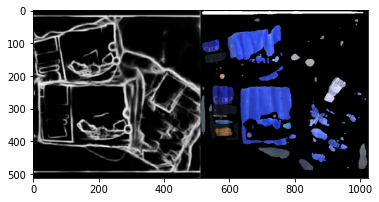

../input/shopee-cv-dnn-image-contour-preprocessed/shopee-dnn-ctr-images/shopee-dnn-ctr-images/6a454ec6206cf0d1f7f5cda04fe3f6ff.jpg


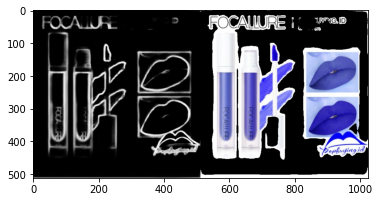

../input/shopee-cv-dnn-image-contour-preprocessed/shopee-dnn-ctr-images/shopee-dnn-ctr-images/b1ffac381119baf5d2cefdc7c3ffc7c7.jpg


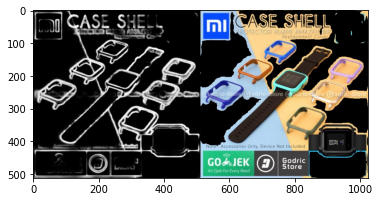

../input/shopee-cv-dnn-image-contour-preprocessed/shopee-dnn-ctr-images/shopee-dnn-ctr-images/51129a188a514d5e7eb644f65cd75bfc.jpg


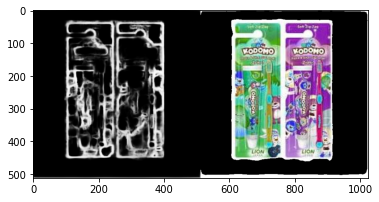

../input/shopee-cv-dnn-image-contour-preprocessed/shopee-dnn-ctr-images/shopee-dnn-ctr-images/01a3cbd7bba577517922af0a3067e4a6.jpg


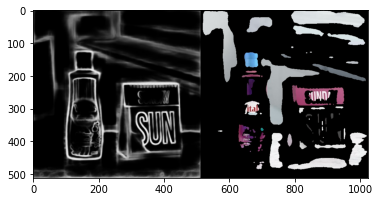

In [61]:
dnn_ctr_imgpaths = glob.glob(f'{cfg.DNN_CTR_IMG_DIRNAME}*.jpg')
dnn_masked_imgpaths = glob.glob(f'{cfg.DNN_MASKED_IMG_DIRNAME}*.jpg')
print(f'Number of H5 contour images: {len(dnn_ctr_imgpaths)}, masked images: {len(dnn_masked_imgpaths)}')

for i in range(10):
    print(dnn_ctr_imgpaths[i])
    img1 = cv2.imread(dnn_ctr_imgpaths[i])
    img2 = cv2.imread(dnn_masked_imgpaths[i])
    
    
    plt.imshow(np.concatenate((img1, img2), axis=1))
    plt.show()

### Post-processing

In [62]:
seed_torch(cfg.SEED)

### Acquiring data

In [63]:
df, df_cu, image_paths = get_dataframe(cfg, cfg.TRAIN_CSV, cfg.TRAIN_DIR, 'image')
df.head()

testloader = get_testloader(cfg, image_paths)

begin_skip_indices: [], end_skip_count: 0, END_IDX: -1
BDUB - df keys: Index(['posting_id', 'image', 'image_phash', 'title', 'label_group'], dtype='object'), df len: 34250
Number of image paths: 34250


In [64]:
# Replace each imagepath in our training set with our DNN contour preprocessed image path
ctr_imgpaths = []
for imgpath in tqdm(image_paths, desc='Replacing training image for DNN contour image'):
    imgname = imgpath.split('/')[-1]
    index = [idx for idx, s in enumerate(dnn_ctr_imgpaths) if imgname in s][0]
    ctr_imgpaths.append(dnn_ctr_imgpaths[index])

dnn_ctr_testloader = get_testloader(cfg, ctr_imgpaths)

Number of image paths: 34250


In [65]:
# Replace each imagepath in our training set with our masked preprocessed image path
ctr_imgpaths = []
for imgpath in tqdm(image_paths, desc='Replacing training image for DNN contour masked image'):
    imgname = imgpath.split('/')[-1]
    index = [idx for idx, s in enumerate(dnn_masked_imgpaths) if imgname in s][0]
    ctr_imgpaths.append(dnn_masked_imgpaths[index])

dnn_masked_testloader = get_testloader(cfg, ctr_imgpaths)

Number of image paths: 34250


### Apply data to model

In [66]:
model = get_model(cfg)

Building Model Backbone for vit_base_patch16_384 model


In [67]:
image_embeddings = get_image_embeddings(cfg, model, testloader)

Acquiring image embeddings: 100%|██████████| 1370/1370 [12:04<00:00,  1.89it/s]


Our image embeddings shape is (34250, 11014)


In [68]:
dnn_ctr_img_embedds = get_image_embeddings(cfg, model, dnn_ctr_testloader)
dnn_masked_img_embedds = get_image_embeddings(cfg, model, dnn_masked_testloader)

Acquiring image embeddings:   0%|          | 0/1370 [00:00<?, ?it/s]

Our image embeddings shape is (34250, 11014)


Acquiring image embeddings: 100%|██████████| 1370/1370 [11:20<00:00,  2.01it/s]


Our image embeddings shape is (34250, 11014)


### Predictions

In [76]:
print(f'Image Predictions: Using {cfg.NUM_KNN}-KNN and image threshold: {cfg.IMG_THRESHOLD}')

Image Predictions: Using 1-KNN and image threshold: 0.42


In [69]:
image_predictions = get_image_predictions(df, image_embeddings, threshold=cfg.IMG_THRESHOLD, num_knn=cfg.NUM_KNN)
dnn_ctr_img_predicts = get_image_predictions(df, dnn_ctr_img_embedds, threshold=cfg.IMG_THRESHOLD, num_knn=cfg.NUM_KNN)
dnn_masked_img_predicts = get_image_predictions(df, dnn_masked_img_embedds, threshold=cfg.IMG_THRESHOLD, num_knn=cfg.NUM_KNN)

Acquiring image predictions: 100%|██████████| 34250/34250 [00:03<00:00, 8902.01it/s]


In [77]:
print(f'Text Predictions: Using {cfg.MAX_FEATS} maximum features and text threshold: {cfg.TXT_THRESHOLD}')

Text Predictions: Using 25000 maximum features and text threshold: 0.75


In [70]:
text_predictions = get_text_predictions(df, df_cu, max_features=cfg.MAX_FEATS, txt_threshold=cfg.TXT_THRESHOLD)

Acquiring text predictions:   0%|          | 0/9 [00:00<?, ?it/s]

Finding similar titles...
chunk 0 to 4096


Acquiring text predictions:  11%|█         | 1/9 [00:03<00:29,  3.68s/it]

chunk 4096 to 8192


Acquiring text predictions:  22%|██▏       | 2/9 [00:07<00:25,  3.68s/it]

chunk 8192 to 12288


Acquiring text predictions:  33%|███▎      | 3/9 [00:11<00:22,  3.76s/it]

chunk 12288 to 16384


Acquiring text predictions:  44%|████▍     | 4/9 [00:14<00:18,  3.72s/it]

chunk 16384 to 20480


Acquiring text predictions:  56%|█████▌    | 5/9 [00:18<00:15,  3.83s/it]

chunk 20480 to 24576


Acquiring text predictions:  67%|██████▋   | 6/9 [00:22<00:11,  3.85s/it]

chunk 24576 to 28672


Acquiring text predictions:  78%|███████▊  | 7/9 [00:26<00:07,  3.80s/it]

chunk 28672 to 32768


Acquiring text predictions:  89%|████████▉ | 8/9 [00:30<00:03,  3.77s/it]

chunk 32768 to 34250


Acquiring text predictions: 100%|██████████| 9/9 [00:31<00:00,  3.51s/it]


### Results

In [71]:
df['image_predictions'] = image_predictions
df['text_predictions'] = text_predictions
df['matches'] = df.apply(combine_predictions, axis=1)

df['f1'] = f1_score(df['true_matches'], df['matches'])
score = df['f1'].mean()
print(f'Our original image F1 score is {score}')

Our original image F1 score is 0.513539262330318


In [72]:
df['image_predictions'] = dnn_ctr_img_predicts
df['text_predictions'] = text_predictions
df['matches'] = df.apply(combine_predictions, axis=1)

df['f1'] = f1_score(df['true_matches'], df['matches'])
score = df['f1'].mean()
print(f'Our CV-DNN contour image preprocessing F1 score is {score}')

Our CV-DNN contour image preprocessing F1 score is 0.49912273987778816


In [73]:
df['image_predictions'] = dnn_masked_img_predicts
df['text_predictions'] = text_predictions
df['matches'] = df.apply(combine_predictions, axis=1)

df['f1'] = f1_score(df['true_matches'], df['matches'])
score = df['f1'].mean()
print(f'Our CV-DNN masked image preprocessing F1 score is {score}')

Our CV-DNN masked image preprocessing F1 score is 0.5371925739705593


In [74]:
# Save submission results
df[['posting_id', 'matches']].to_csv('submission.csv', index=False)

In [75]:
score_perclass = f1_score_perclass(df, 'label_group', 'f1')
with open('f1_score_perclass.csv', 'w') as f1_score_csv:
    f1_score_csv.write(f'label_group, f1_score')
    for key in score_perclass.keys():
        f1_score_csv.write(f'\n{key}, {score_perclass[key]}')